<a href="https://colab.research.google.com/github/QingyunSun/Distributional-Robust-Kelly-Gambling/blob/master/DRKP20190704_final_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
get_ipython().run_line_magic('pylab', 'inline')
import numpy as np
import cvxpy as cvx
import itertools

n = 20 # number of assets
K = int(n*(n-1)/2)# number of scenarios

# Monte Carlo sample
MC_N_SAMPLES = 100
MC_T = 50

N_TRAJ = 30
OFFSET = 2


std = 0.5
seed = 2018
print('seed', seed)
np.random.seed(seed)


# #### Helper functions 

def simulate_trajectories(sampled_returns, b):
    """Simulate log-wealth trajectories."""
    N_SAMPLES, T, n = sampled_returns.shape
    return np.hstack([np.zeros((N_SAMPLES, 1)),
                      np.cumsum(np.log(np.dot(sampled_returns, b)), axis=1)])

def growth_rate_Wmins(logw_samples):
    """Simulate expected log growth rate and samples W_min."""
    T = logw_samples.shape[1] - 1
    return mean(logw_samples[:,-1])/T, np.exp(np.min(logw_samples, axis=1))

def drawdown_prob(W_mins, alpha):
    return sum(W_mins < alpha)/float(len(W_mins))

def empirical_cdf(samples, grid):
    return array([sum(samples <= el) for el in grid], dtype=float) / len(samples)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# # Definitions 

skill = np.random.randn(n)


beta = softmax( std*(skill))
beta /= sum(beta)

TopTwoList = list(itertools.combinations(range(n),2))

pi = np.ones(K)

pi_unif = np.ones(K)/K

r = np.zeros((n,K))


for count in range(len(TopTwoList)):
    vector = np.zeros(n)
    first_place = TopTwoList[count][0]
    second_place = TopTwoList[count][1]
    total = beta[first_place]+beta[second_place]
    vector[first_place] = n*beta[second_place]/total
    vector[second_place] = n*beta[first_place]/total
    r[:,count]=vector

    pi[count] = beta[second_place]*beta[first_place]*(1/(1-beta[first_place])+ 1/(1-beta[second_place]))
    
pi /= sum(pi)



mc_sample = r[:, np.random.choice(r.shape[1], size = MC_N_SAMPLES * MC_T, p = pi)]
R = r



Populating the interactive namespace from numpy and matplotlib
seed 2018


In [0]:
# generate_ball_problem
  
pi_0 = cvx.Parameter(K, nonneg=True)
c = cvx.Parameter((1,1), nonneg=True)
b = cvx.Variable(n)
F = cvx.Variable(K)
#       mu = cvx.Variable(1)
# mu = cvx.Variable(K)
log_growth = cvx.log(r.T*b )
rob_growth_rate = pi_0.T*F-c*cvx.norm(F-cvx.sum(F)*np.ones(K)/K,2)
# rob_growth_rate = rob_growth_rate -pi_0.T*cvx.abs(mu  )-rho.T*mu 
constraints = [cvx.sum(b ) == 1, b  >= 0,  F<= log_growth] 
DRKP = cvx.Problem(cvx.Maximize(rob_growth_rate), constraints)

probl_rob = DRKP




##########
List_wealth_Knom_ball = []
List_wealth_Kbad_ball = []
List_wealth_RKnom_ball = []
List_wealth_RKbad_ball = []
List_L_ball = []
List_B_ball = []
List_pi_KW_ball = []
List_pi_RKW_ball = []

for uncertain_ratio_star in np.linspace(0,0.02,21):

    B = []
    L_growth = []

    # pi_0 is true
    pi_0.value = pi


    for uncertain_ratio in [0., uncertain_ratio_star]:

  #       bound = uncertain_ratio *pi_unif

  #       c.value = uncertain_ratio



        c.value = np.array([[uncertain_ratio]])
  #       print('c', c.value)

        probl_rob.solve(solver = 'SCS')

  #       print('Kelly:uncertain_ratio',uncertain_ratio)
  #       print('bet new',b.value)
        B.append(b.value)
        L_growth.append(log_growth.value)





    ################

    # find worst deviation for Kelly
    delta0 = cvx.Variable(K)

    constraints = [cvx.sum(delta0 ) == 0, pi+delta0 >= 0, cvx.norm(delta0,2)<= c] 
    obj0 = (pi+delta0).T*L_growth[0]
    worst_Prob= cvx.Problem(cvx.Minimize(obj0), constraints)

    worst_Prob.solve(solver = 'SCS')
    Delta0 = delta0.value



    # find worst deviation for DRKP
    delta1 = cvx.Variable(K)

    constraints = [cvx.sum(delta1 ) == 0, pi+delta1 >= 0, cvx.norm(delta1,2)<= c] 
    obj1 = (pi+delta1).T*L_growth[1]
    worst_Prob= cvx.Problem(cvx.Minimize(obj1), constraints)

    worst_Prob.solve(solver = 'SCS')
    Delta1 = delta1.value


    pi_Kw = pi+Delta0
    pi_RKw = pi+Delta1
    pi_Kw = np.maximum(0,pi_Kw)
    pi_RKw = np.maximum(0,pi_RKw)
    pi_Kw /= sum(pi_Kw)
    pi_RKw /= sum(pi_RKw)




    #####################

  #   print("Uncertainty:", uncertain_ratio_star)
  #   print("Wealth:")
  #   print(pi.dot(L_growth[0]))
  #   print(pi.dot(L_growth[1]))
  #   print(pi_Kw.dot(L_growth[0]), obj0.value)
  #   print(pi_RKw.dot(L_growth[1]),obj1.value)
    List_wealth_Knom_ball.append(pi.dot(L_growth[0]))
    List_wealth_RKnom_ball.append(pi.dot(L_growth[1]))
    List_wealth_Kbad_ball.append(obj0.value)
    List_wealth_RKbad_ball.append(obj1.value)
    List_B_ball.append(B)
    List_L_ball.append(L_growth)
    List_pi_KW_ball.append(pi_Kw)
    List_pi_RKW_ball.append(pi_RKw)

In [0]:

# generate_box_prob

pi_0 = cvx.Parameter(K, nonneg=True)
rho = cvx.Parameter(K, nonneg=True)
b = cvx.Variable(n)
mu = cvx.Variable(K)
log_growth = cvx.log(r.T*b )
rob_growth_rate = cvx.min(log_growth + mu  )
rob_growth_rate = rob_growth_rate -pi_0.T*(mu  )-rho.T*cvx.abs(mu)
constraints = [cvx.sum(b ) == 1, b  >= 0] 
DRKP = cvx.Problem(cvx.Maximize(rob_growth_rate), constraints)

probl_rob = DRKP



##########
List_wealth_Knom_box = []
List_wealth_Kbad_box = []
List_wealth_RKnom_box = []
List_wealth_RKbad_box = []
List_L_box = []
List_B_box = []
List_pi_KW_box = []
List_pi_RKW_box = []

for uncertain_ratio_star in np.linspace(0,0.3,31):

  B = []
  L_growth = []

  # pi_0 is true
  pi_0.value = pi

  
  for uncertain_ratio in [0., uncertain_ratio_star]:

      bound = uncertain_ratio *pi_unif

      rho.value = bound

      probl_rob.solve(solver = 'SCS')

#       print('Kelly:uncertain_ratio',uncertain_ratio)
#       print('bet new',b.value)
      B.append(b.value)
      L_growth.append(log_growth.value)





  ################

  # find worst deviation for Kelly
  delta0 = cvx.Variable(K)

  constraints = [cvx.sum(delta0 ) == 0, pi+delta0 >= 0, cvx.abs(delta0)<= bound] 
  obj0 = (pi+delta0).T*L_growth[0]
  worst_Prob= cvx.Problem(cvx.Minimize(obj0), constraints)

  worst_Prob.solve(solver = 'SCS')
  Delta0 = delta0.value



  # find worst deviation for DRKP
  delta1 = cvx.Variable(K)

  constraints = [cvx.sum(delta1 ) == 0, pi+delta1 >= 0, cvx.abs(delta1)<= bound] 
  obj1 = (pi+delta1).T*L_growth[1]
  worst_Prob= cvx.Problem(cvx.Minimize(obj1), constraints)

  worst_Prob.solve(solver = 'SCS')
  Delta1 = delta1.value


  pi_Kw = pi+Delta0
  pi_RKw = pi+Delta1
  pi_Kw = np.maximum(0,pi_Kw)
  pi_RKw = np.maximum(0,pi_RKw)
  pi_Kw /= sum(pi_Kw)
  pi_RKw /= sum(pi_RKw)




  #####################

#   print("Uncertainty:", uncertain_ratio_star)
#   print("Wealth:")
#   print(pi.dot(L_growth[0]))
#   print(pi.dot(L_growth[1]))
#   print(pi_Kw.dot(L_growth[0]), obj0.value)
#   print(pi_RKw.dot(L_growth[1]),obj1.value)
  List_wealth_Knom_box.append(pi.dot(L_growth[0]))
  List_wealth_RKnom_box.append(pi.dot(L_growth[1]))
  List_wealth_Kbad_box.append(obj0.value)
  List_wealth_RKbad_box.append(obj1.value)
  List_B_box.append(B)
  List_L_box.append(L_growth)
  List_pi_KW_box.append(pi_Kw)
  List_pi_RKW_box.append(pi_RKw)

<Figure size 864x432 with 0 Axes>

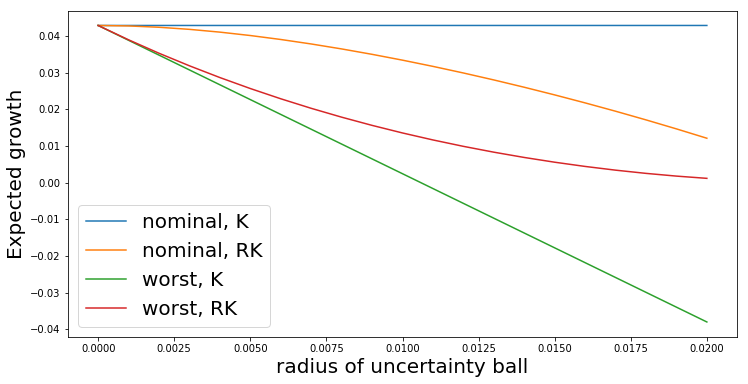

In [0]:

params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
plt.rcParams.update(params)

x = np.linspace(0,0.02,21)
# plt.plot(x,List_wealth_Knom)
figure(figsize(12,6))
f, (ax) = subplots(1, 1, sharey=True)

plt.plot(x, List_wealth_Knom_ball,label = "nominal, K")
plt.plot(x, List_wealth_RKnom_ball,label = "nominal, RK")
plt.plot(x, List_wealth_Kbad_ball,label = "worst, K")
plt.plot(x, List_wealth_RKbad_ball,label = "worst, RK")
# ax.set_xlabel("radius of uncertainty set")
ax.set_xlabel("radius of uncertainty ball",  size = 20)
ax.set_ylabel("Expected growth", size = 20 )
plt.legend( loc=3)
# ax.set_ylabel("percentage expected growth  ")
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

<Figure size 864x432 with 0 Axes>

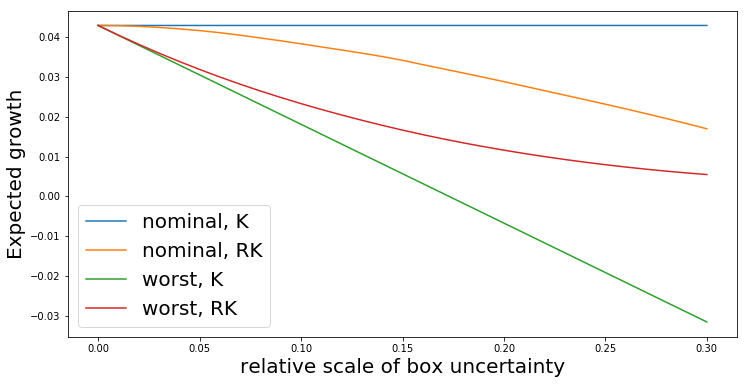

In [0]:

params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
plt.rcParams.update(params)

x = np.linspace(0,0.3,31)
# plt.plot(x,List_wealth_Knom)
figure(figsize(12,6))
f, (ax) = subplots(1, 1, sharey=True)

plt.plot(x, List_wealth_Knom_box,label = "nominal, K")
plt.plot(x, List_wealth_RKnom_box,label = "nominal, RK")
plt.plot(x, List_wealth_Kbad_box,label = "worst, K")
plt.plot(x, List_wealth_RKbad_box,label = "worst, RK")
# ax.set_xlabel("radius of uncertainty set")
ax.set_xlabel("relative scale of box uncertainty",  size = 20)
ax.set_ylabel("Expected growth", size = 20 )
plt.legend( loc=3)
# ax.set_ylabel("percentage expected growth  ")
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [0]:
bK = List_B_ball[0][0]

bRK_box = List_B_box[26][1]

bRK_ball = List_B_ball[16][1]



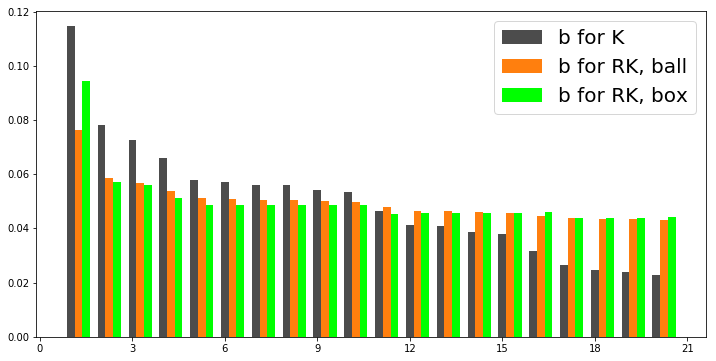

In [0]:
from matplotlib.ticker import MaxNLocator

ax = plt.subplot(111)
width = 0.25
barWidth = 0.25
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

index = np.argsort(bK)[::-1]
plt.bar(  np.arange(1,n+1), bK[index], width=barWidth, label='b for K',lw=1,alpha = 0.7, fc=(0, 0, 0, 0.5))
plt.bar(  np.arange(1,n+1)+width, bRK_ball[index],width=barWidth, label='b for RK, ball' )
plt.bar(  np.arange(1,n+1)+2*width, bRK_box[index] ,width=barWidth, label='b for RK, box', fc=(0, 1, 0, 1) )
#   List_B[i][1]
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend( loc=1)

plt.show()

In [0]:
# def Worst_Case_Prob(bK, bRK, pi, r):
#   ################

#   # find worst deviation for Kelly
#   delta0 = cvx.Variable(K)

#   constraints = [cvx.sum(delta0 ) == 0, pi+delta0 >= 0, cvx.norm(delta0,2)<= c] 
#   obj0 = (pi+delta0).T* cvx.log(r.T*bK )
#   worst_Prob= cvx.Problem(cvx.Minimize(obj0), constraints)

#   worst_Prob.solve(solver = 'SCS')
#   Delta0 = delta0.value



#   # find worst deviation for DRKP
#   delta1 = cvx.Variable(K)

#   constraints = [cvx.sum(delta1 ) == 0, pi+delta1 >= 0, cvx.norm(delta1,2)<= c] 
#   obj1 = (pi+delta1).T*cvx.log(r.T*bRK )
#   worst_Prob= cvx.Problem(cvx.Minimize(obj1), constraints)

#   worst_Prob.solve(solver = 'SCS')
#   Delta1 = delta1.value


#   pi_Kw = pi+Delta0
#   pi_RKw = pi+Delta1
#   pi_Kw = np.maximum(0,pi_Kw)
#   pi_RKw = np.maximum(0,pi_RKw)
#   pi_Kw /= sum(pi_Kw)
#   pi_RKw /= sum(pi_RKw)
  
#   return pi_Kw, pi_RKw

  

In [0]:
List_pi_RKW_box[26]

array([0.00452828, 0.00894018, 0.00312269, 0.00437387, 0.00385192,
       0.00449309, 0.00492427, 0.00373568, 0.00422229, 0.00438856,
       0.00445767, 0.00305972, 0.00445903, 0.00497455, 0.0044847 ,
       0.00318487, 0.00424253, 0.00333135, 0.00414329, 0.01462834,
       0.00409226, 0.00538287, 0.00673524, 0.00480153, 0.00551636,
       0.00368096, 0.00514843, 0.00541053, 0.00475366, 0.00399449,
       0.0055388 , 0.00847717, 0.00771714, 0.0041888 , 0.00447042,
       0.00441621, 0.00504375, 0.00483062, 0.01398679, 0.01705874,
       0.00966859, 0.01118988, 0.0069953 , 0.01345412, 0.01404963,
       0.00954357, 0.00460822, 0.01434105, 0.02101364, 0.01928834,
       0.00505024, 0.00878437, 0.00556754, 0.01321627, 0.00398284,
       0.00450684, 0.00324678, 0.00350602, 0.00279143, 0.00389201,
       0.00399356, 0.00322548, 0.00238505, 0.00404326, 0.00381438,
       0.00488758, 0.00246028, 0.00309614, 0.00254834, 0.00385145,
       0.00640993, 0.00463565, 0.00528145, 0.00354561, 0.00488

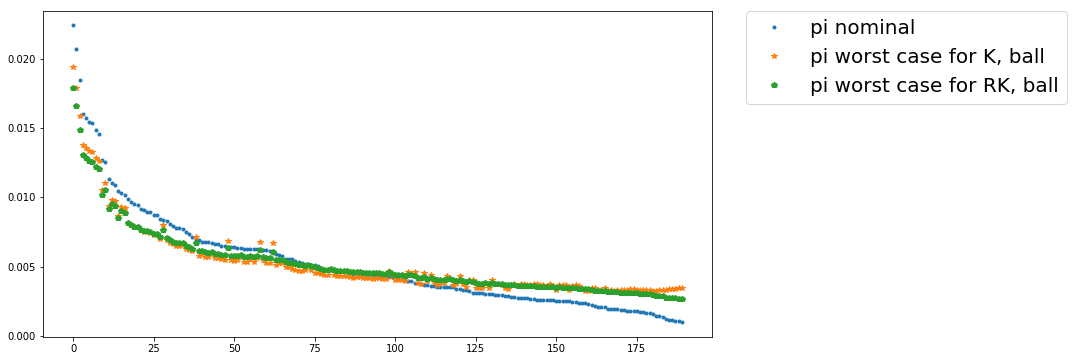

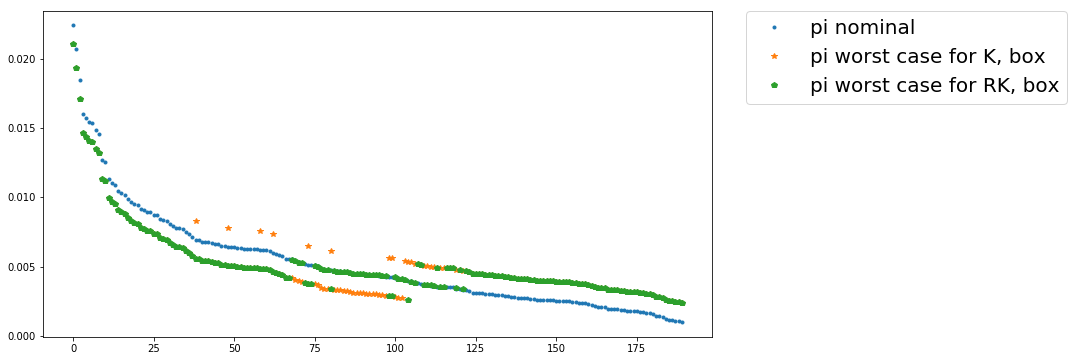

In [0]:


pi_Kw_ball, pi_RKw_ball = List_pi_KW_ball[16],List_pi_RKW_ball[16]
pi_Kw_box, pi_RKw_box = List_pi_KW_box[26],List_pi_RKW_box[26]

plt.subplot(111)
width = 0.2
barWidth = 0.4

order = np.argsort(pi)[::-1]
plt.plot(  pi[order] , '.', label='pi nominal')
plt.plot(  pi_Kw_ball[order], '*', label='pi worst case for K, ball')
plt.plot(  pi_RKw_ball[order], 'p' ,label='pi worst case for RK, ball')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()


plt.subplot(111)
width = 0.2
barWidth = 0.4

order = np.argsort(pi)[::-1]
plt.plot(  pi[order] , '.', label='pi nominal')
plt.plot(  pi_Kw_box[order], '*', label='pi worst case for K, box')
plt.plot(  pi_RKw_box[order], 'p' ,label='pi worst case for RK, box')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

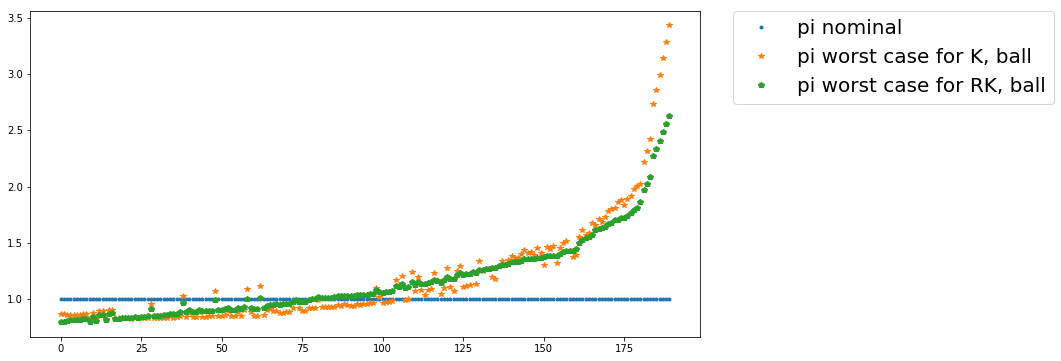

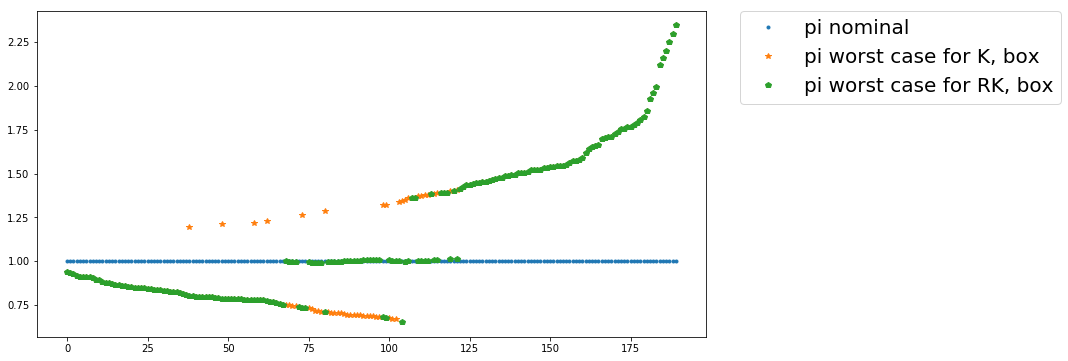

In [0]:
plt.subplot(111)
width = 0.2
barWidth = 0.4

order = np.argsort(pi)[::-1]
plt.plot(  pi[order]/pi[order] , '.', label='pi nominal')
plt.plot(  pi_Kw_ball[order]/pi[order], '*', label='pi worst case for K, ball')
plt.plot(  pi_RKw_ball[order]/pi[order], 'p' ,label='pi worst case for RK, ball')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()


plt.subplot(111)
width = 0.2
barWidth = 0.4

order = np.argsort(pi)[::-1]
plt.plot(  pi[order]/pi[order] , '.', label='pi nominal')
plt.plot(  pi_Kw_box[order]/pi[order], '*', label='pi worst case for K, box')
plt.plot(  pi_RKw_box[order]/pi[order], 'p' ,label='pi worst case for RK, box')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()